# COMP5329 - Deep Learning
## Tutorial 2 - Multilayer Neural Network

**Semester 1, 2025**


# MLP implementation

## Loading the packages

In [1]:
import numpy as np
import matplotlib.pyplot as pl
from ipywidgets import interact, widgets
from matplotlib import animation

 ## The Dataset
The following script allows you to create a 2D dataset by using the mouse. The left click adds points belonging to class A (blue), and the right click adds points belonging to class B (red). You can create as many points as you desire. The final dataset will contain hence three values per point: x coordinate [-1,1], y coordinate [-1,1] and the class {1,-1}.

In [ ]:
# create the figure
fig = pl.figure(figsize=(6,6))
pl.title("Input Dataset")
pl.xlim((-2,2))
pl.ylim((-2,2))

dataset = []

# setting the click event
def onclick(event):
    global dataset
    cx = event.xdata
    cy = event.ydata
    co = event.button
    dataset.append((cx, cy, co-2))

    pl.scatter(cx, cy, c=(['b', 'r'])[co > 2], s=100, lw=0)
    pl.grid(True)

cid = fig.canvas.mpl_connect('button_press_event', onclick)

<IPython.core.display.Javascript object>

In [ ]:
%matplotlib inline

## Show the dataset

In [ ]:
# # Un-comment this code block if you are using Google Colab
class_1 = np.hstack([np.random.normal( 1, 1, size=(25, 2)),  np.ones(shape=(25, 1))])
class_2 = np.hstack([np.random.normal(-1, 1, size=(25, 2)), -np.ones(shape=(25, 1))])
dataset = np.vstack([class_1, class_2])
dataset

array([[ 1.51991933,  1.28810666,  1.        ],
       [ 1.23738789,  1.25902881,  1.        ],
       [ 0.49364083,  1.43742822,  1.        ],
       [ 0.76540804, -0.23870427,  1.        ],
       [ 0.80808229,  0.7671803 ,  1.        ],
       [ 0.23023993,  1.60829228,  1.        ],
       [ 1.0694576 ,  0.80562279,  1.        ],
       [ 1.42018848,  0.91292364,  1.        ],
       [ 0.75111982,  2.136958  ,  1.        ],
       [ 0.20226851,  0.86803623,  1.        ],
       [-0.355314  ,  0.1500552 ,  1.        ],
       [ 1.975677  ,  2.00170934,  1.        ],
       [ 3.1227652 , -0.57916347,  1.        ],
       [ 1.03790128, -0.29550575,  1.        ],
       [ 2.08965684,  0.65184001,  1.        ],
       [ 2.69565669, -0.35138153,  1.        ],
       [ 0.48644515,  1.70774426,  1.        ],
       [ 1.92572422,  0.48421064,  1.        ],
       [ 0.75459987,  1.17306507,  1.        ],
       [ 1.01507787,  1.71647388,  1.        ],
       [ 1.81369734,  0.30362923,  1.   

<IPython.core.display.Javascript object>

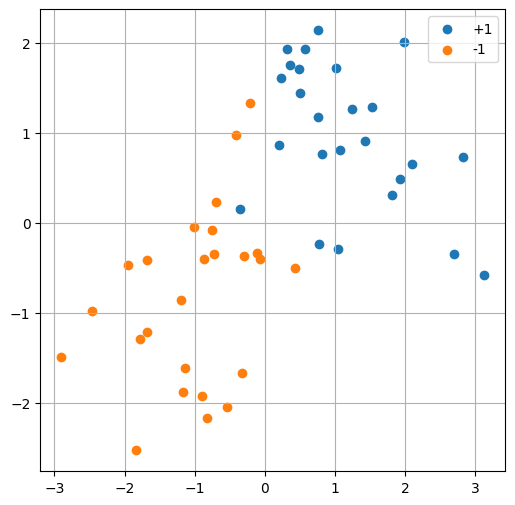

In [ ]:
pl.figure(figsize=(6, 6))
pl.scatter(class_1[:,0], class_1[:,1], label='+1')
pl.scatter(class_2[:,0], class_2[:,1], label='-1')
pl.grid()
pl.legend()
pl.show()

## Definition of some activation functions

Linear
$$output = x$$

Tanh  
$$output = tanh(x)$$  

Sigmoid
$$output = \frac {1}{1 + e^{-x}}$$

MSE loss: ||z - t||^2 -> 2 (z - t)

In [ ]:
# create a activation class
# for each time, we can initiale a activation function object with one specific function
# for example: f = Activation("tanh")  means we create a tanh activation function.
# you can define more activation functions by yourself, such as relu!

class Activation(object):
    def __tanh(self, x):
        return np.tanh(x)

    def __tanh_deriv(self, a):
        # a = np.tanh(x)
        return 1.0 - a**2 # 1 - a^2 | a = tanh(x)    a is not equal to x a != x
    def __logistic(self, x):
        return 1.0 / (1.0 + np.exp(-x)) # logistic = sigmoid

    def __logistic_deriv(self, a):
        # a = logistic(x)
        return  a * (1 - a )

    def __init__(self,activation='tanh'):
        if activation == 'logistic':
            self.f = self.__logistic
            self.f_deriv = self.__logistic_deriv
        elif activation == 'tanh':
            self.f = self.__tanh
            self.f_deriv = self.__tanh_deriv

In [ ]:
next()

### Define HiddenLayer

$$output = f\_act(\sum_{i=0}^{1}{(I_{i} * W_{i})} + b)$$

In [ ]:
# now we define the hidden layer for the mlp
# for example, h1 = HiddenLayer(10, 5, activation="tanh") means we create a layer with 10 dimension input and 5 dimension output, and using tanh activation function.
# notes: make sure the input size of hiddle layer should be matched with the output size of the previous layer!

class HiddenLayer(object):
    def __init__(self,n_in, n_out,
                 activation_last_layer='tanh',activation='tanh', W=None, b=None):
        """
        Typical hidden layer of a MLP: units are fully-connected and have
        sigmoidal activation function. Weight matrix W is of shape (n_in,n_out)
        and the bias vector b is of shape (n_out,).

        NOTE : The nonlinearity used here is tanh

        Hidden unit activation is given by: tanh(dot(input,W) + b)

        :type n_in: int
        :param n_in: dimensionality of input

        :type n_out: int
        :param n_out: number of hidden units

        :type activation: string
        :param activation: Non linearity to be applied in the hidden
                           layer
        """
        self.input=None
        self.activation=Activation(activation).f

        # activation deriv of last layer
        self.activation_deriv=None
        if activation_last_layer:
            self.activation_deriv=Activation(activation_last_layer).f_deriv

        # we randomly assign small values for the weights as the initiallization
        self.W = np.random.uniform(
                low=-np.sqrt(6. / (n_in + n_out)),
                high=np.sqrt(6. / (n_in + n_out)),
                size=(n_in, n_out)
        )
        # if activation == 'logistic':
        #     self.W *= 4

        # we set the size of bias as the size of output dimension
        self.b = np.zeros(n_out,)

        # we set he size of weight gradation as the size of weight
        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)


    # the forward and backward progress (in the hidden layer level) for each training epoch
    # please learn the week2 lec contents carefully to understand these codes.
    def forward(self, input):
        '''
        :type input: numpy.array
        :param input: a symbolic tensor of shape (n_in,)
        '''
        # I . W + b
        lin_output = np.dot(input, self.W) + self.b
        self.output = (
            lin_output if self.activation is None
            else self.activation(lin_output)
        )
        self.input=input

        # shape_output = self.output.shape
        # rd_indices = np.random.randint(0, shape_output[0], shape_output[0] * 0.6)
        # self.output[rd_indices] *= 0.0
        # self.output = self.output/(1- 0.6)
        return self.output

    def backward(self, delta, output_layer=False):
        self.grad_W = np.atleast_2d(self.input).T.dot(np.atleast_2d(delta))
        self.grad_b = delta
        if self.activation_deriv:
            delta = delta.dot(self.W.T) * self.activation_deriv(self.input) # activation layer derivative given input
        return delta

## The MLP

The class implements a MLP with a fully configurable number of layers and neurons. It adapts its weights using the backpropagation algorithm in an online manner.

In [ ]:
class MLP:
    """
    """

    # for initiallization, the code will create all layers automatically based on the provided parameters.
    def __init__(self, layers, activation=[None,'tanh','tanh']):
        """
        :param layers: A list containing the number of units in each layer.
        Should be at least two values
        :param activation: The activation function to be used. Can be
        "logistic" or "tanh"
        """
        ### initialize layers
        self.layers=[]
        self.params=[]

        self.activation=activation
        for i in range(len(layers)-1):
            self.layers.append(HiddenLayer(layers[i],layers[i+1],activation[i],activation[i+1]))

    # forward progress: pass the information through the layers and out the results of final output layer
    def forward(self,input):
        for layer in self.layers:
            output=layer.forward(input)  # layer <- HiddenLayer.forward
            input=output
        return output

    # define the objection/loss function, we use mean sqaure error (MSE) as the loss
    # you can try other loss, such as cross entropy.
    # when you try to change the loss, you should also consider the backward formula for the new loss as well!
    def criterion_MSE(self,y,y_hat):
        activation_deriv=Activation(self.activation[-1]).f_deriv
        # MSE
        error = y-y_hat
        loss=error**2
        # calculate the MSE's delta of the output layer 2 * (z1 - t)
        delta=-2 * error*activation_deriv(y_hat) # (z1 - t)^2 -> 2 (z1 - t) * act_deriv(z1)
        # return loss and delta
        return loss,delta

    # backward progress
    def backward(self,delta):
        delta=self.layers[-1].backward(delta,output_layer=True)
        for layer in reversed(self.layers[:-1]):
            delta=layer.backward(delta)

    # update the network weights after backward.
    # make sure you run the backward function before the update function!
    def update(self,lr):
        for layer in self.layers:
            layer.W -= lr * layer.grad_W
            layer.b -= lr * layer.grad_b

    # define the training function
    # it will return all losses within the whole training process.
    def fit(self,X,y,learning_rate=0.1, epochs=100):
        """
        Online learning.
        :param X: Input data or features
        :param y: Input targets
        :param learning_rate: parameters defining the speed of learning
        :param epochs: number of times the dataset is presented to the network for learning
        """
        X=np.array(X)
        y=np.array(y)
        to_return = np.zeros(epochs)

        for k in range(epochs):
            loss=np.zeros(X.shape[0])
            for it in range(X.shape[0]):
                i=np.random.randint(X.shape[0])

                # forward pass
                y_hat = self.forward(X[i])

                # backward pass
                loss[it],delta=self.criterion_MSE(y[i],y_hat)
                self.backward(delta)
                y
                # update
                self.update(learning_rate)
            to_return[k] = np.mean(loss)
        return to_return

    # define the prediction function
    # we can use predict function to predict the results of new data, by using the well-trained network.
    def predict(self, x):
        x = np.array(x)
        output = np.zeros(x.shape[0])
        for i in np.arange(x.shape[0]):
            output[i] = self.forward(x[i,:])
        return output

## Learning

In [ ]:
### Try different MLP models
nn = MLP([2,3,1], [None,'logistic','tanh'])
input_data = dataset[:,0:2]
output_data = dataset[:,2]

In [ ]:
### Try different learning rate and epochs
MSE = nn.fit(input_data, output_data, learning_rate=0.001, epochs=500)
print('loss:%f'%MSE[-1])

<ipython-input-9-f7361d0b0adb>:77: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  loss[it],delta=self.criterion_MSE(y[i],y_hat)


loss:0.114649


#### Plot loss in epochs
We can visualize the loss change during the training process, to under how we can the network. As we can see, the loss staies at the large level at the beginning, but drop quickly within the training. A small loss value indicate a well-trained network.

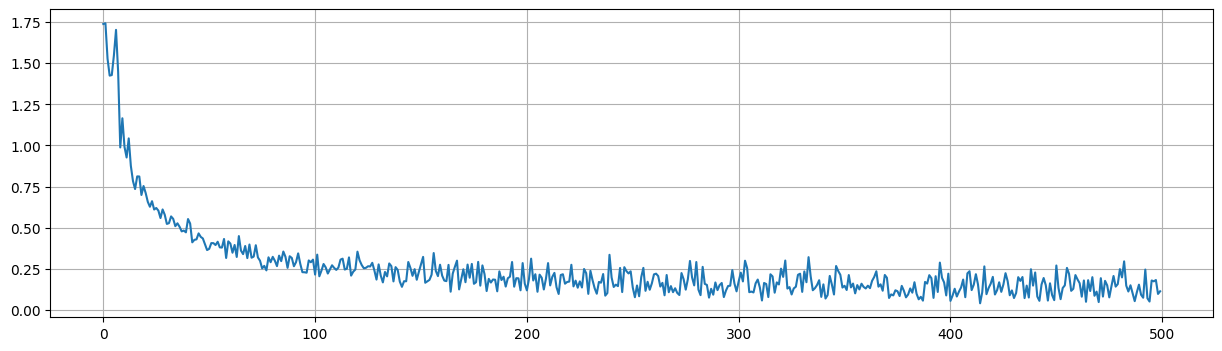

In [ ]:
pl.figure(figsize=(15,4))
pl.plot(MSE)
pl.grid()

<ipython-input-9-f7361d0b0adb>:77: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  loss[it],delta=self.criterion_MSE(y[i],y_hat)


loss:0.406961


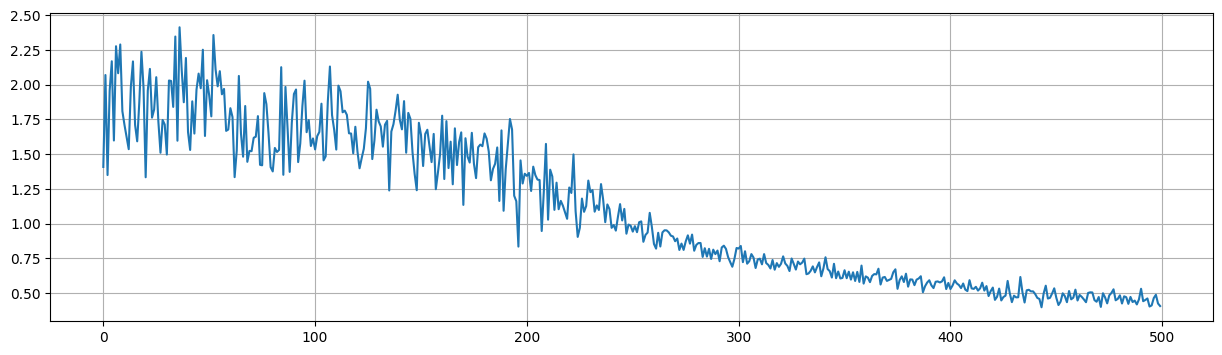

In [ ]:
### Try different MLP models
# we can compare the loss change graph to under how the network parameters (such as number of layers and activation functions),
# could affect the performance of network.
nn = MLP([2,3,1], [None,'logistic','tanh'])
input_data = dataset[:,0:2]
output_data = dataset[:,2]
MSE = nn.fit(input_data, output_data, learning_rate=0.0001, epochs=500)
print('loss:%f'%MSE[-1])
pl.figure(figsize=(15,4))
pl.plot(MSE)
pl.grid()

<ipython-input-9-f7361d0b0adb>:77: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  loss[it],delta=self.criterion_MSE(y[i],y_hat)


loss:0.080158


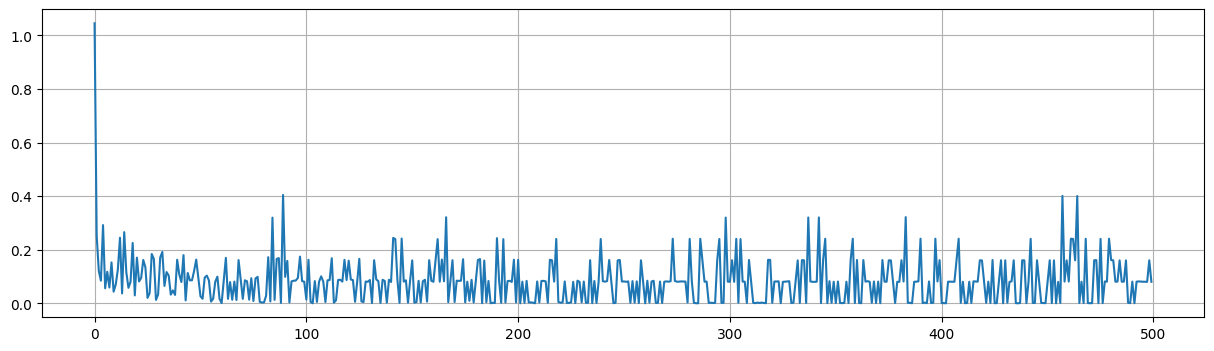

In [ ]:
### Try different MLP models
nn = MLP([2,3,1], [None,'logistic','tanh'])
input_data = dataset[:,0:2]
output_data = dataset[:,2]
MSE = nn.fit(input_data, output_data, learning_rate=0.1, epochs=500)
print('loss:%f'%MSE[-1])
pl.figure(figsize=(15,4))
pl.plot(MSE)
pl.grid()

## Testing

In [ ]:
output = nn.predict(input_data)

<ipython-input-9-f7361d0b0adb>:91: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output[i] = self.forward(x[i,:])


In [ ]:
print(output)

[ 0.99802392  0.99792662  0.99710552  0.98527294  0.99737533  0.99450497
  0.99777786  0.99798412  0.99770258  0.84275334 -0.99890299  0.99805105
  0.99818002  0.99595224  0.99820414  0.99813381  0.99737292  0.99812458
  0.99758108  0.99782734  0.99803189  0.99693517  0.99697467  0.99758892
  0.99840226 -0.99968462 -0.99926994 -0.99956422 -0.99957969 -0.99960642
 -0.99955971 -0.99896274 -0.99897494 -0.99933058 -0.99767173 -0.99935347
 -0.99966204 -0.99919956 -0.99961406 -0.92744866 -0.99954266 -0.99962336
 -0.99953941 -0.9991132  -0.99954746 -0.99940478 -0.99958276 -0.93078825
 -0.99958877 -0.99950596]


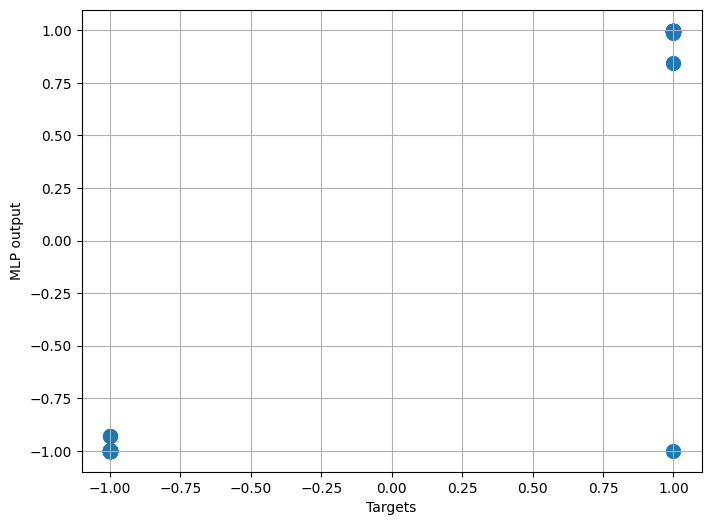

In [ ]:
# visualizing the predict results
# notes: since we use tanh function for the final layer, that means the output will be in range of [-1,1]
pl.figure(figsize=(8,6))
pl.scatter(output_data, output, s=100)
pl.xlabel('Targets')
pl.ylabel('MLP output')
pl.grid()

<ipython-input-9-f7361d0b0adb>:91: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output[i] = self.forward(x[i,:])
<ipython-input-18-a681fe8476c4>:14: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  pl.scatter(input_data[:,0], input_data[:,1], c=[(['b', 'r'])[d>0] for d in output_data], s=100)
<ipython-input-18-a681fe8476c4>:21: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  pl.scatter(input_data[:,0], input_data[:,1], c=[(['b', 'r'])[d>0] for d in output], s=100)


Text(0.5, 1.0, 'MLP output')

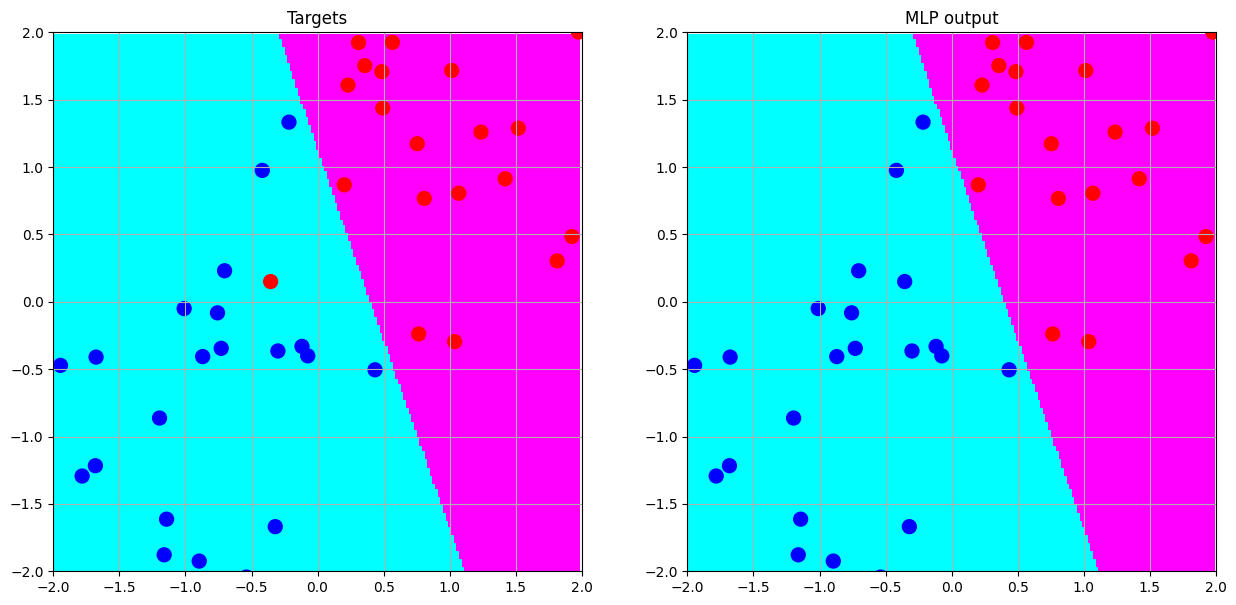

In [ ]:
# create a mesh to plot in
xx, yy = np.meshgrid(np.arange(-2, 2, .02),np.arange(-2, 2, .02))

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
Z = nn.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

pl.figure(figsize=(15,7))
pl.subplot(1,2,1)
pl.pcolormesh(xx, yy, Z>0, cmap='cool')
pl.scatter(input_data[:,0], input_data[:,1], c=[(['b', 'r'])[d>0] for d in output_data], s=100)
pl.xlim(-2, 2)
pl.ylim(-2, 2)
pl.grid()
pl.title('Targets')
pl.subplot(1,2,2)
pl.pcolormesh(xx, yy, Z>0, cmap='cool')
pl.scatter(input_data[:,0], input_data[:,1], c=[(['b', 'r'])[d>0] for d in output], s=100)
pl.xlim(-2, 2)
pl.ylim(-2, 2)
pl.grid()
pl.title('MLP output')

the figure on the left shows the ground true label of each data

the figure on the eright shows the predict label of each data with MLP model.

Based on the visualization result, we can find that network learned a boundary between positive and negative data!


# MLP in LLAMA

The fully connected layer is the traditional MLP, a multi-layer linear layer. In the LLaMA model, multiple linear layers are added to perform gating operations on the output.

The structure of this model is shown in the diagram below.

The shape of $x$ is: [batch_size, seq_len, hidden_size]

The output shape of self.gate_proj is: [batch_size, seq_len, intermediate_size]

The output shape of self.up_proj is: [batch_size, seq_len, intermediate_size]

The output shape of self.down_proj is: [batch_size, seq_len, hidden_size]

![本地路径](./mlp_llama.png "相对路径演示")

In [2]:
# Import necessary modules
from torch import nn
import transformers
import torch
import torch.nn.functional as F
from transformers.activations import ACT2FN

# Print the installed transformers version
print("Transformers version:", transformers.__version__)  # Expected: 4.34.0.dev0

# Display available activation functions in transformers
ACT2FN

Transformers version: 4.49.0


ClassInstantier([('gelu', transformers.activations.GELUActivation),
                 ('gelu_10',
                  (transformers.activations.ClippedGELUActivation,
                   {'min': -10, 'max': 10})),
                 ('gelu_fast', transformers.activations.FastGELUActivation),
                 ('gelu_new', transformers.activations.NewGELUActivation),
                 ('gelu_python',
                  (transformers.activations.GELUActivation,
                   {'use_gelu_python': True})),
                 ('gelu_pytorch_tanh',
                  transformers.activations.PytorchGELUTanh),
                 ('gelu_accurate',
                  transformers.activations.AccurateGELUActivation),
                 ('laplace', transformers.activations.LaplaceActivation),
                 ('leaky_relu', torch.nn.modules.activation.LeakyReLU),
                 ('linear', transformers.activations.LinearActivation),
                 ('mish', transformers.activations.MishActivation),
        

In [3]:
# Define the LLaMA MLP Class

class LlamaMLP(nn.Module):
    def __init__(self, config):
        """
        Implements the MLP block of the LLaMA model.

        Args:
            config (object): Configuration object containing model parameters.
        """
        super().__init__()

        # Store the model configuration
        self.config = config

        # Hidden layer size (e.g., 4096 for LLaMA-7B)
        self.hidden_size = config.hidden_size  

        # Intermediate size (typically a multiple of hidden_size, e.g., 4x larger)
        self.intermediate_size = config.intermediate_size  

        # Gate projection layer: Projects hidden_size → intermediate_size
        self.gate_proj = nn.Linear(self.hidden_size, self.intermediate_size, bias=False)

        # Up projection layer: Expands hidden_size → intermediate_size
        self.up_proj = nn.Linear(self.hidden_size, self.intermediate_size, bias=False)

        # Down projection layer: Reduces intermediate_size → hidden_size
        self.down_proj = nn.Linear(self.intermediate_size, self.hidden_size, bias=False)

        # Activation function (e.g., SiLU, GELU, ReLU) as specified in config
        self.act_fn = ACT2FN[config.hidden_act]

    def forward(self, x):
        """
        Forward pass of the LLaMA MLP block.

        Args:
            x (Tensor): Input tensor of shape [batch_size, seq_len, hidden_size]

        Returns:
            Tensor: Output tensor of shape [batch_size, seq_len, hidden_size]
        """
        
        # Check if tensor parallelism is enabled
        if self.config.pretraining_tp > 1:
            # If pretraining_tp > 1, split tensor computation for parallelism
            slice = self.intermediate_size // self.config.pretraining_tp  # Partition size

            # Split weights along the intermediate size dimension
            gate_proj_slices = self.gate_proj.weight.split(slice, dim=0)  # List of tensors [slice, hidden_size]
            up_proj_slices = self.up_proj.weight.split(slice, dim=0)  # Similar split for up_proj
            down_proj_slices = self.down_proj.weight.split(slice, dim=1)  # Splitting along columns for down_proj

            # Apply linear transformations to each partition and concatenate results
            gate_proj = torch.cat(
                [F.linear(x, gate_proj_slices[i]) for i in range(self.config.pretraining_tp)], dim=-1
            )
            up_proj = torch.cat(
                [F.linear(x, up_proj_slices[i]) for i in range(self.config.pretraining_tp)], dim=-1
            )

            # Apply activation function and element-wise multiplication
            intermediate_states = (self.act_fn(gate_proj) * up_proj).split(slice, dim=2)

            # Compute final down projection
            down_proj = [
                F.linear(intermediate_states[i], down_proj_slices[i]) for i in range(self.config.pretraining_tp)
            ]
            
            # Sum all parts to reconstruct the full output
            down_proj = sum(down_proj)
        
        else:
            # Standard computation without tensor parallelism
            down_proj = self.down_proj(self.act_fn(self.gate_proj(x)) * self.up_proj(x))

        return down_proj



In [4]:
# Testing Tensor Slicing for Parallel Computation

# Create a sample linear layer with 16 input features and 32 output features
linear_layer = torch.nn.Linear(16, 32, bias=False)

# Print the weight tensor shape
print("Original weight shape:", linear_layer.weight.shape)  # Expected: torch.Size([32, 16])

# Split weights along rows (dim=0)
linear_layer_slice_row = linear_layer.weight.split(8, dim=0)
print("Number of row slices:", len(linear_layer_slice_row))  # Expected: 4 slices
print("Shape of each row slice:", linear_layer_slice_row[0].shape)  # Expected: torch.Size([8, 16])

# Split weights along columns (dim=1)
linear_layer_slice_column = linear_layer.weight.split(8, dim=1)
print("Number of column slices:", len(linear_layer_slice_column))  # Expected: 2 slices
print("Shape of each column slice:", linear_layer_slice_column[0].shape)  # Expected: torch.Size([32, 8])


Original weight shape: torch.Size([32, 16])
Number of row slices: 4
Shape of each row slice: torch.Size([8, 16])
Number of column slices: 2
Shape of each column slice: torch.Size([32, 8])


### Key Takeaways

1. The LlamaMLP Class Implements LLaMA's MLP Block:

* Uses three projection layers: gate_proj, up_proj, and down_proj.
* Applies gating and activation functions before reducing dimensions.

2. Supports Tensor Parallelism (pretraining_tp):
* If pretraining_tp > 1, splits the model weights for parallel computation.
* Splitting reduces computational overhead across multiple devices.

3. Manually Implements Tensor Slicing:
* The split() function divides tensor weights for distributed operations.
* Example:
    * Splitting along rows partitions weights for independent linear operations.
    * Splitting along columns optimizes down projection.